<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Pset 4: Problems Using Numerical Simulation</h1>


<a name='section_4_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P4.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_1">P4.1 Double Pendulum</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_4_1">P4.1 Problems</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_2">P4.2 Lattice-Boltzmann Simulation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_4_2">P4.2 Problems</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_3">P4.3 Monte Carlo Simulation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_4_3">P4.3 Problems</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_4">P4.4 Simulating a partial differential equation: the time dependent Ginzburg Landau (TDGL) equation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_4_4">P4.4 Problems</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_5">P4.5 Solving differential equations with neural nets</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_4_5">P4.5 Problems</a></td>
    </tr>
</table>



<h3>Learning Objectives</h3>

In these problems, we will explore several examples utilizing numerical simulation. For each case, there will be several questions which lead to building a full-fledged simulation of the physical system or computational task under consideration. Specifically, we will explore the following:

- Double-pendulum
- Lattice-Boltzmann simulation
- Monte Carlo simulation
- Simulating a partial differential equation: the time dependent Ginzburg Landau (TDGL) equation
- Solving differential equations with neural nets

<h3>Importing Libraries</h3>

Before beginning, run the cell below to import the relevant libraries for this notebook.

In [ ]:
#>>>RUN: P4.0-runcell00

#install the following:

#conda install -c conda-forge imageio
#pip install imageio
#pip3 install torch torchvision torchaudio

In [ ]:
#>>>RUN: P4.0-runcell01

from scipy.integrate import odeint
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image
import random

<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.

In [ ]:
#>>>RUN: P4.0-runcell02

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title


<a name='section_4_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P4.1 Double Pendulum</h2>    

| [Top](#section_4_0) | [Previous Section](#section_4_0) | [Problems](#problems_4_1) | [Next Section](#section_4_2) |


<h3>Overview</h3>

The double pendulum is a system in classical mechanics where one pendulum is attached to the end of another pendulum. Its equations of motion are usually expressed using the Lagrangian mechanics and solved numerically, which is what we will do in this problem

In [ ]:
#Below is a reworking of 
#https://scipython.com/blog/the-double-pendulum/
#https://github.com/zaman13/Double-Pendulum-Motion-Animation/blob/master/Python%20Code/Double_Pendulum_v1.py

## Setting up the differential equations to be solved

def theta1ddot(theta1,theta1dot,theta2,theta2dot,m,ell,g):
        st1t2=np.sin(theta1-theta2)
        ct1t2=np.cos(theta1-theta2)
        term1=-m*ell**2*st1t2*(ct1t2*theta1dot**2 + theta2dot**2)
        term2= m*g*ell*(-2*np.sin(theta1)+np.sin(theta2)*ct1t2)
        denom=m*ell**2*(1+st1t2**2)
        return (term1+term2)/denom

def theta2ddot(theta1,theta1dot,theta2,theta2dot,m,ell,g):
        st1t2=np.sin(theta1-theta2)
        ct1t2=np.cos(theta1-theta2)
        term1=m*ell**2*st1t2*(ct1t2*theta2dot**2 + 2*theta1dot**2)
        term2=2*m*g*ell*(-np.sin(theta2)+np.sin(theta1)*ct1t2)
        denom=m*ell**2*(1+st1t2**2)
        return (term1+term2)/denom


def ode(y, t, l, m, g):
    """Return the first derivatives of y = theta1, z1, theta2, z2."""
    theta1, theta1dot, theta2, theta2dot = y
    t1ddt=theta1ddot(theta1,theta1dot,theta2,theta2dot,m,l,g)
    t2ddt=theta2ddot(theta1,theta1dot,theta2,theta2dot,m,l,g)
    return theta1dot,t1ddt,theta2dot,t2ddt

def energy(y,l,m,g):
    theta1, theta1dot, theta2, theta2dot = y.T # Note the.T transposes it so we can unpack
    ct1t2=np.cos(theta1-theta2)
    U=-2*m*g*l*np.cos(theta1)-m*g*l*np.cos(theta2)
    K=m*l**2*theta1dot**2+m*l**2/2*(theta2dot**2+2*theta1dot*theta2dot*ct1t2)
    return K+U

## set up pendulum parameters
l=5#m
m=1#kg
g=9.8#kgm/s^2

<a name='problems_4_1'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_1) | [Next Section](#section_4_2) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.1.1</span>

Later in this problem when doing the numerics, one parameter we can easily calculate is the energy of the system. Before doing any numerics, is energy conserved in this system?


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.1.2</span>

Report the total energy for systems with the following initial conditions (consider four separate cases and report your answer as a list of number with precision 1e-1): `[energy case1, energy case2, energy case3, energy case4]`

Case 1: no initial amplitude, no initial angular velocity\
Case 2: small initial amplitude of pendulum 1 only (other initial conditions zero): `theta1=0.02*pi`\
Case 3: larger initial amplitude of both pendula (angular velocities zero): `theta1=0.3*pi`, `theta2=0.2*pi`\
Case 4: nearly vertical (angular velocities zero): `theta1=0.9*pi`, `theta2=*pi`

In [ ]:
#>>>PROBLEM: P4.1.2
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

#define arrays for the 4 cases by setting the initial conditions in y0,
#e.g., y0_case1=np.array([theta1_case1, theta1dot_case1, theta2_case1, theta2dot_case1])

y0_case1 = #YOUR CODE HERE
y0_case2 = #YOUR CODE HERE
y0_case3 = #YOUR CODE HERE
y0_case4 = #YOUR CODE HERE

#print the energy for each case, using `energy(y,l,m,g)`

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.1.3</span>

Before doing a simulation, it can be useful to think about test cases where you know the answer to check your simulation outputs. One simple way to decompose a system is into normal modes. 


Which of the following statements is true about the normal modes of a double-pendulum system?

A) There is only one normal mode, which is called the out-of-phase mode.\
B) There are two normal modes, which are called the in-phase mode and the out-of-phase mode.\
C) There are three normal modes, which are called the in-phase mode, the out-of-phase mode, and the chaotic mode.\
D) There are four normal modes, which are called the in-phase mode, the out-of-phase mode, the chaotic mode, and the stable mode.



<h3>Run the Simulation</h3>

Now run the cells below to see the simulation.

In [ ]:
## Solve the differenial equation with odeint and make a video of the bob's motion
def run(y0):

    # y0 is the initial conditions theta1, theta1dot, theta2, theta2dot = y
    # for example y0=np.array([np.pi*0.1,0,np.pi*0.2,0])
    
    #Time
    tmax=30#s
    dt=1e-2#s
    t=np.arange(0, tmax+dt, dt)

    #The works
    y = odeint(ode, y0, t, args=(l,m,g))
    #print(y)
    
    #the check
    en=energy(y,l,m,g)
    
    return t,y,en
    
    
#===========Plotting 
def make_plot(i,y,l,g,ax,fig,images):
    plt.cla()
    # Plot and save an image of the double pendulum configuration for time
    # point i.
    # The pendulum rods.
    theta1=y[:,0]
    theta2=y[:,2]
    x1 = l  * np.sin(theta1)
    y1 = -l * np.cos(theta1)
    x2 = x1 + l * np.sin(theta2)
    y2 = y1 - l * np.cos(theta2)
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k')

    # Circles representing the anchor point of rod 1, and bobs 1 and 2.
    r = 0.35
    c0 = patches.Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = patches.Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
    c2 = patches.Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # The trail will be divided into ns segments and plotted as a fading line.
    ns = 20
    trail_secs = 1
    dt=1e-2#s
    max_trail = int(1 / dt)
    s = max_trail // ns

    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0:
            continue
        imax = imin + s + 1
        # The fading looks better if we square the fractional length along the
        # trail.
        alpha = (j/ns)**2
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(-l-l-r, l+l+r)
    ax.set_ylim(-l-l-r, l+l+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    fps = 10
    di = int(1/fps/dt)
    # plt.savefig('frames/_img{:04d}.png'.format(i//di), dpi=72)
    # plt.cla()
    #plt.show()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

In [ ]:
#set the initial conditions and run the simulation

#Define a new y0, or test cases defined previously
#e.g.,y0=y0_case1
#y0 = #YOUR CODE HERE

y0=y0_case3

t,y,en=run(y0)

fps = 1000
dt=.0001
di = int(1/fps/dt)
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

# Create the output of the simulation, stored in the variable `images`
images=[]
for i in range(0, t.size, di):
    #print(i // di, '/', t.size // di)
    make_plot(i,y,l,g,ax,fig,images)
    

# Comment out plt.close() to view the last image from the simulation, if desired
plt.close()

#save the gif
imageio.mimsave('./double_p.gif', images, fps=10)

In [ ]:
# VIEW THE GIF
# comment out the line and run again to hide

#Image(open('double_p.gif','rb').read())

In [ ]:
## plot the bobs' angles vs time and energy
## use previously defined y0, above

plt.plot(t,y[:,0],color='blue')
plt.plot(t,y[:,2],color='red')
plt.xlabel("Time [seconds]")
plt.ylabel(r"$\theta$")
plt.show()


plt.plot(t,en,color='blue')
plt.xlabel("Time [seconds]")
plt.ylabel("Energy")
plt.show()

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)
make_plot(10,y,l,g,ax,fig,images)
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.1.4</span>

For each of the following initial conditions, describe the bob's motion. To do this, edit and run the relevant code above and analyze plots of $\theta$ vs. $t$ for each case.

<pre>
#initial conditions:
y0_case1=np.array([0,0,0,0])
y0_case2=np.array([np.pi*0.02,0,np.pi*0.0,0])
y0_case3=np.array([np.pi*0.3,0,np.pi*0.2,0])
y0_case4=np.array([np.pi*.9,0,np.pi*1,0]) 
</pre>

Select your answer for each case from the following options:

A) Stationary\
B) Each bob oscillates at a single frequency\
C) Each bob oscillates periodically and displays beats\
D) One bob oscillates periodically and one bob oscillates chaotically\
E) Both bobs oscillate chaotically


Enter your answer as a list of **uppercase** letters, corresponding to the correct choices for each set of initial conditions, i.e.: `[answer case1, answer case2, answer case3, answer case4 ]` should be entered as, e.g., `['A','B','C','D']`, where the letters are **capitalized** and listed as strings.

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.1.5</span>


Is energy conserved during the evolution for each of the above initial conditions? Try plotting the energy in each case to determine your answer.

A) Yes.\
B) No, the energy fluctuates significantly as the pendula move.\
C) No, the energy decays significantly when the bobs are moving.

<a name='section_4_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P4.2 Lattice-Boltzmann Simulation</h2>    

| [Top](#section_4_0) | [Previous Section](#section_4_1) | [Problems](#problems_4_2) | [Next Section](#section_4_3) |


<h3>Overview</h3>

Lattice Boltzmann modelling using grid systems. 
Based on the below: 
https://physics.weber.edu/schroeder/javacourse/LatticeBoltzmann.pdf 

Also: 
https://medium.com/swlh/create-your-own-lattice-boltzmann-simulation-with-python-8759e8b53b1c?source=user_profile---------4----------------------------

The goal of this project is to do a numerical modelling of the the flow momentum using a lattice. To perform this, we will rely on the fact that the momenta of particles are distributed following a Boltzmann distribution. 

$$ D(\vec{v}) = \frac{m}{2\pi k T} e^{-\frac{mv^2}{kT}} $$

What this means is that when we look at a motionless system the migration in an out of grid is still happening. 

Furthermore, what this means is that motion in and out can be depicted by the speed of sound in the gas, given by 

$$ c_{s} = \sqrt{\langle v_{x}^2+v_{y}^2+v_{z}^2} = \sqrt{3\langle v_{x}^2\rangle}= \sqrt{\frac{3kT}{m}} $$

Mesoscopic model, which is in between microscopic model that describes particle positions and macroscopic models that describe velocity and density directly. LBM instead describes the probability of particles being in various locations.

The computational idea of the model invoves two steps: a collision step where particles reorganize and relax to equillibrium and a streaming step where the results of the collision are propogated and each cell is updated.

Weights determine the equillibrium density and are set by which model we choose. Changing the weights will change the results and here we choose the D2Q9 model, which tells us that we are working in dimension 2 and the density has 9 possible velocity vectors. The 9 possible velocity vectors correspond to the 8 adjacent cells about a center cell (ie 3x3 grid). Velocity motion can go on the diagonals, and as a result we have 8 possible motions to different cells and one stay motion. 

The D2Q9 weights can be derived by integrating the boltzman distribution in the 9 possible directions.  Following the grid shown here: 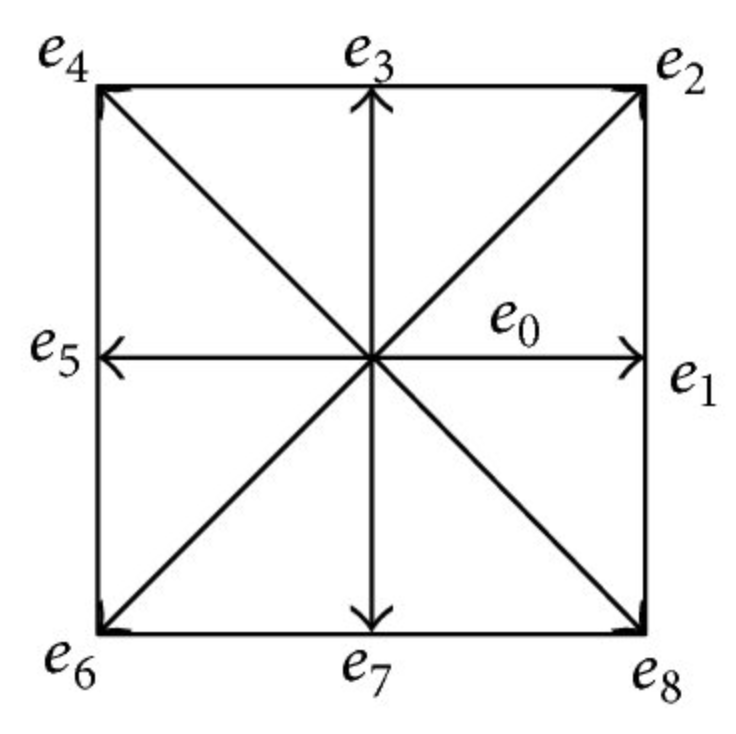

In [ ]:
idx = np.arange(9)
cxs = np.array([0, 0, 1, 1, 1, 0,-1,-1,-1]) ## for velocities in the x direction
cys = np.array([0, 1, 1, 0,-1,-1,-1, 0, 1]) ## for velocities in the y direction
ws  = np.array([4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36]) ## weights for D2Q9

In [ ]:
#Some references
#https://d-nb.info/1070218804/34
#https://github.com/KnairdA/LiterateLB/blob/master/lbm.org => This covers the problem and goes way deeper
#https://arxiv.org/pdf/1909.04502.pdf

In a lattice-Boltzmann simulation, the fundamental dynamical variables are the
nine different number densities of particles moving at the nine allowed velocities,
at each lattice site. Thus, your simulation will need nine two-dimensional arrays
of real numbers to represent these densities

At any given time, at a given lattice site, these nine densities can have any
positive values. From these values you can then compute the total density, ρ, as
well as the x and y components of the average (that is, macroscopic) velocity, ux
and uy

<a name='problems_4_2'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_2) | [Next Section](#section_4_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.2.1</span>

Write a function to compute the total density at each lattice site, summing over the 9 allowed velocities.

In [ ]:
#>>>PROBLEM: P4.2.1
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

## 
def globalRho(rho):
    # input is a density array (rho)
    #,2 index is over the velocity directions
    return #YOUR CODE HERE


#-----------------------------------------------------
# CHECK YOUR RESULT

#rho is a 3d array that is Nx x Ny x 9, where there are 9 Nx x Ny densities,
#and each of those densities has one of the 9 possible velocity options.

np.random.seed(42)

Nx=100
Ny = 100
NL = 9
var=0.01
rho = (np.ones((Ny,Nx,NL)) + var*np.random.randn(Ny,Nx,NL))
gRho = globalRho(rho)


print(rho.shape)
print(gRho.shape)

fig, ax = plt.subplots()
im = ax.imshow(gRho, cmap='plasma')
ax.set_title('Global Density')
fig.colorbar(im, ax=ax)
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.2.2</span>

Write a function to compute the velocity.

In [ ]:
#>>>PROBLEM: P4.2.2
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

def globalV(rho,gRho):
    # input is a density array (rho) and the total density gRho
    #,2 index is over the velocity directions
    ux = ##YOUR CODE HERE
    uy = ##YOUR CODE HERE
    return ux,uy

#-----------------------------------------------------
# CHECK YOUR RESULT

np.random.seed(42)

Nx=100
Ny = 100
NL = 9
var=0.01
rho = (np.ones((Ny,Nx,NL)) + var*np.random.randn(Ny,Nx,NL))
gRho = globalRho(rho)

gUx,gUy  = globalV(rho,gRho)

# What are the shapes of the arrays
print(gUx.shape)
#print(gUx.shape)

# Plot the output of the function
fig, ax = plt.subplots()
im = ax.imshow(gUx, cmap='plasma')
ax.set_title('Global Ux')
fig.colorbar(im, ax=ax)
plt.show()

Now we will rearrange the Boltzmann distribution, which tells us the probability that a particle has a particular thermal velocity, $\vec{v}$, into a form useful for our simulation. The total velocity determined by our simulation is one of the nine options from D2Q9. We will constrain our total velocity $\vec{u}+\vec{v}$, which is the sum of the flow velocity $\vec{u}$ and the thermal velocity $\vec{v}$ to be equal to $c \vec{e}_i$.

We can rearannge the probability distribution function to become

$D(\vec{v})→ \frac{m}{2\pi k T} e^{-\frac{m}{2kT}|\vec{e}_i c - \vec{u}|^2}$

Further, we require that $v << c$ so that particles do not have an appreciable chance to move 2 lattice steps per time step. By expanding square term in the exponential and then taylor expanding each term, we find the first factor corresponds to the probability of having velocity $c \vec{e_i}$ when the flow velocity is 0, which is exactly the weight $w_i$.

This leads to the equation

$D(\vec{v})→ w_i \big( 1 + \frac{3 \vec{e_i} \cdot \vec{u}}{c} + \frac{9}{2} (\frac{\vec{e_i} \cdot \vec{u}}{c})^2 -\frac{3}{2}\frac{|\vec{u}|^2}{c}  \big) $

From here on, we will set the speed of sound to 1, $c=1$. This is effectively our new Boltzman distribution when we know have a wind of velocity $\vec{u}$.

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.2.3</span>

What is the equation for the equillibrium density? Express your answer using `Dv` for the probability density $D(\vec{v})$, and `rho` for the density $\rho$.

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.2.4</span>

Complete the code below to update `rho` in the simulation. To do this, define `rhoeq_func` using the definition of the equillibrium density derived above.

In [ ]:
#>>>PROBLEM: P4.2.4
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

def rhoeq_func(w,gRho,cx,cy,gUx,gUy):
    return #YOUR CODE HERE
    
def updateRho(rho,gRho,gUx,gUy,step):
    rhoeq=np.zeros(rho.shape)
    for i,cx,cy,w in zip(idx,cxs,cys,ws):
        rhoeq[:,:,i] = rhoeq_func(w,gRho,cx,cy,gUx,gUy)
    rho += step*(rhoeq-rho)
    return rho
    

In [ ]:
#>>>RUN

## Other code DESCRBE WHY THIS CODE MATTERS
def moveParts(rho):
    for i,cx,cy in zip(idx,cxs,cys):
        #Shift each velocity index by appropriate neighbor density
        rho[:,:,i] = np.roll(rho[:,:,i],cx,axis=1)
        rho[:,:,i] = np.roll(rho[:,:,i],cy,axis=0)
    
def vorticity(ux,uy):
    #input is ux and uy grids
    #output is vorticity grid
    #nabla\times u 
    #0.5(u(x+dx)-u(x-dx)) - (u(y+dy)-u(y-dy))
    vort = 0.5*(np.roll(ux,-1,axis=0)-np.roll(ux,1,axis=0) -(np.roll(uy,-1,axis=0)-np.roll(uy,1,axis=0)))
    return vort


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.2.5</span>

Complete the following function, the purpose of which is to implement reflecting boundary conditions by updating the density values at the boundary with the reflected values.

The function selects the rows of the `rhoOld` array that correspond to the boundary, and assigns it to a variable called `bndryRho` (this is already done). The function should then select the columns of `bndryRho` using the `ref` array to invert the directions, and assign the resulting array back to `bndryRho`. Finally, the reflected `bndryRho` array should be assigned back to the `rho` array at the rows corresponding to the boundary. 

In [ ]:
#>>>PROBLEM: P4.2.5
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

def reflect(rho,rhoOld,boundary):
    #Invert all the velocity directions
    ref = np.array([0, 5, 6, 7, 8, 1, 2, 3, 4])#map to invert velocity 0->0 1=>5
    bndryRho = rhoOld[boundary,:]
    bndryRho = ## YOURE CODE HERE
    rho[boundary,:] = ## YOURE CODE HERE
    return rho

    
    
#-----------------------------------------------------
# CHECK YOUR RESULT

np.random.seed(42)

Nx=100
Ny = 100
NL = 9
var=0.01
rho = (np.ones((Ny,Nx,NL)) + var*np.random.randn(Ny,Nx,NL))

X, Y = np.meshgrid(range(Nx), range(Ny))
rho[:,:,3] += 1  #* (1+0.2*np.cos(2*np.pi*X/Nx*4))
cylinder = (X - Nx/4)**2 + (Y - Ny/2)**2 < (Ny/8)**2


#Before reflect
rho1 = rho.flatten()
print(rho1)
print()

#After reflect
reflect(rho,rho,cylinder)
rho2 = rho.flatten()
print(rho2)
print()

#check diff
print(rho2-rho1)

<h3>Run the Simulation</h3>

Now run the cells below to see the simulation, which uses the functions you have defined above.

In [ ]:
import numpy as np

def mapPlot(ax,fig, iArr, i, Nx, Ny,boundary, images):
    plt.cla()
    X, Y = np.meshgrid(range(Nx), range(Ny))
    #plt.setp(sp.get_yticklabels(), visible=False)
    #plt.setp(sp.get_xticklabels(), visible=False)
    ax.pcolormesh(X, Y, 1-boundary, cmap='gray',alpha=0.3);
    ax.pcolormesh(X, Y, iArr, cmap=plt.cm.RdBu,clim=(-0.1,0.1));
    ax.text(0.6, 0.3,'Time=%d'%i,fontdict={'size': 24, 'color':  'red'})#; plt.axis('tight')    
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image  = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

def simulate(ntries = 250, Nx=100, Ny = 100, var=0.01, timestep=1.): 
    fig, ax = plt.subplots(figsize=(12,7))
    NL = 9
    viscosity=1.3
    timestep=timestep*viscosity
    #create density rho with some random 
    rho = (np.ones((Ny,Nx,NL)) + var*np.random.randn(Ny,Nx,NL))
    X, Y = np.meshgrid(range(Nx), range(Ny))
    rho[:,:,3] += 1  #* (1+0.2*np.cos(2*np.pi*X/Nx*4))
    cylinder = (X - Nx/4)**2 + (Y - Ny/2)**2 < (Ny/8)**2
    #rho[cylinder,:]=100./9.
    images = []
    for i in range(ntries):
        #rhoOld = rho.copy()
        gRho     = globalRho(rho)
        gUx,gUy  = globalV(rho,gRho)
        vort     = vorticity(gUx,gUy)
        rho = updateRho(rho,gRho,gUx,gUy,timestep)
        moveParts(rho)
        rho = reflect(rho,rho,cylinder)        
        mapPlot(ax,fig,vort,i,Nx,Ny,cylinder,images)
        if i % 50 == 0:
            print(i)
    return images
  
# Create the output of the simulation, stored in the variable `images`
# Comment out plt.close() to view the last image from the simulation, if desired
images=simulate()
plt.close()

# save the output stored in the variable `images`, and create a gif
imageio.mimsave('./test.gif', images, fps=10)



In [ ]:
# VIEW THE GIF
# comment out the line and run again to hide

Image(open('test.gif','rb').read())

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.2.6</span>

What happens if we remove the initial density fluctuations? Check all that apply:

A) The simulation remains static\
B) The simulation evolves\
C) A flat density distribution will remain flat under the LB equations\
D) A flat density distribution is not the equillibrium density distribution so it becomes nonuniform under the LB equations

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.2.7</span>

What if we increase the initial density ripples by a factor of 10 from the initial value? Change the variable var in the simulation from 0.01 to 0.1. Check all that apply:

A) Small lengthscale density fluctuations are visible at early times\
B) At intermediate times, the density profile is smooth with long wavelength density variations\
C) At intermediate times, small lengthscale density fluctuations become scattering centers\
D) At long times the density profile is too turbulent to make out distinct wave patterns\
E) At long times, the initial density fluctuations impact the wave pattern, which is asymmetric because of the small scale fluctuations

<a name='section_4_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P4.3 Monte Carlo Simulation</h2>    

| [Top](#section_4_0) | [Previous Section](#section_4_2) | [Problems](#problems_4_3) | [Next Section](#section_4_4) |


<h3>Overview</h3>

Rarefied flows cannot be accurately simulated using fluid (Navier-Stokes) equations. By rarified or ‘dilute’, we mean that the mean free path λ of a molecule is of the same order (or greater) than a representative physical length scale L in the problem. This occurs in low atmospher objects. 

In this case the gas cannot be considered as a continuum medium and the Boltzmann transport equation must be used to understand the physics of the system. In addition, due to the increased surface-to-volume ratio, the details of the gas interaction with the (solid or liquid) boundaries gain increasing importance as compared to standard fluid dynamics.


Consider dilute gas in thermal equilibrium with temperature T₀ between two infinite long plates.

The top plate is a relective (specular) wall which will simply bounce back particles that hit it. The bottom plate is a thermal wall with temperature Tw=T₀ that suddenly moves in the y-direction with speed uw at time t=0. The wall is moving tangentially to its normal, the total size of the box is not changing during the simulation. The plates are separated by a distance Lz along the z-direcion. To analyze this gas, we will break up the gas into ‘collision’ cells of height dz. For this prolem, we would like to understand "the Rayleigh problem", which is to understand how the dilute gas will react to the sudden movement of the plate.

The DSMC method will treat the dilute gas as a collection of simulation particles, each with:

position `rᵢ = [ xᵢ, yᵢ, zᵢ ]` , and\
velocity `vᵢ = [ vxᵢ, vyᵢ, vzᵢ ]`

It is important to note that each simulation particle may represent Nₑ physical particles, where Nₑ need not be 1.

In a loop over time steps, the particles will undergo three steps, which you will write below:

1) Drift\
2) Wall Collisions\
3) Particle-Particle Collisions (via probabilistic Monte Carlo)

<a name='problems_4_3'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_3) | [Next Section](#section_4_4) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.3.1</span>

What do you expect to happen to the particle velocities as the plate is moved?

A) Expect the velocity fluctuations to increase\
B) Expect the velocity to increase\
C) Expect the velocity to decrease\
D) Expect the velocity fluctuations to decrease

<h3>Setting up the simulation parameters</h3>


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import special
# Simulation parameters
uw              = 0.2       # lower wall velocity
Tw              = 1         # wall temperature
n0              = 0.001     # density
N               = 50000     # number of sampling particles
Nsim            = 3         # number of simulations to run
Ncell           = 50        # number of cells
Nmft            = 20        # number of mean-free times to run simulation
plotRealTime    = False # True      # animate
	
Nt              = Nmft*25                    # number of time steps (25 per mean-free time)
lambda_mfp      = 1/(np.sqrt(2)*np.pi*n0)    # mean free path ~= 225
Lz              = 10*lambda_mfp              # height of box  ~= 2250.8
Kn              = lambda_mfp / Lz            # Knudsen number  = 0.1
v_mean = (2/np.sqrt(np.pi)) * np.sqrt(2*Tw)  # mean speed
tau             = lambda_mfp / v_mean        # mean-free time
dt              = Nmft*tau/Nt                # timestep
dz              = Lz/Ncell                   # cell height
vol             = Lz*dz*dz/Ncell             # cell volume
Ne              = n0*Lz*dz*dz/N   # number of real particles each sampling particle represents
	
# vector for recording v_y(z=0)
vy0 = np.zeros((Nsim,Nt))    

# set the random number generator seed
np.random.seed(17) 

# prep figure
fig = plt.figure(figsize=(4,4), dpi=80)
ax = plt.gca()
plt.close()

<h3>Step 1: Drift</h3>

Next we will write the code for the three steps of the simulation. First the drift step, which involves shifting a particle's position by a distance that is equal to its velocity at the beginning of the time step times the length of the time step.

$\vec{r}_i = \vec{r}_i+\Delta t \vec{v}_i$


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.3.2</span>

How do we write a drift function? Write a function that acts on a single component of the position vector and updates the position based on the dispalcement formula: $\vec{r}_i = \vec{r}_i+\Delta t \vec{v}_i$



In [ ]:
#>>>PROBLEM: P4.3.2
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.


def drift(x,vx,dt):
  return ## YOUR CODE HERE

<h3>Step 2: Wall Collisions - Top Wall</h3>

In the next step, particles collide with the walls. These are the boundary conditions for the problem.

The top wall is reflective and a particle hits the top wall if its position becomes z>Lz. In such a case, we must trace the straight-line trajectory of the top wall and bounce it back. The particle position is reflected across top wall, and the normal component of the velocity (vz) reverses sign.



### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.3.3</span>

Implement the boundary condition for the reflective top wall in the function below:

In [ ]:
#>>>PROBLEM: P4.3.3
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

#hit_top = z > Lz

def reverse_velocity(vz,hit_top):
  vz[hit_top] = ## YOUR CODE HERE
  return vz[hit_top]

<h3>Step 2: Wall Collisions - Bottom Wall</h3>

Next, the bottom thermal wall needs to be accounted for. A particle hits the wall if its position becomes $z<0$. In this case, the particle’s velocity needs to be reset to a biased Maxwellian upon impact:

The x velocity distribution is Maxwellian with temrpature of the wall $T_{w}$ giving a sampled velocity of $v^{i}_{x}$ for $r^{i}_{G}$ a sampled Gaussian of width 1. 

$$ {\rm pdf} (v_x) = C e^{-\frac{mv^2}{kT_{w}}} \rightarrow v^{i}_{x} = \sqrt{\frac{k T_w}{m}}r^{i}_G
$$

The y-th velocity now as the added velocity of the moving wall yielding a sampled value of 

$$ v^{i}_{y} = \sqrt{\frac{k T_w}{m}}r^{i\prime}_G+u_w$$

The z-th velocity is a maxwellian gradient along the wall

$$ v_Z = \sqrt{-\frac{2k T_w}{m} \ln{r}}$$

where r_G and r’_G are numbers drawn from a random Gaussian, and r is drawn randomly from the uniform interval (0,1). $T_w$ is the temperature of the wall and $u_w$ is the velocity of the wall.

Following the point of impact, the particle streams off with its new velocity, so its position needs to be corrected to take that into account.

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.3.4</span>


Implement the boundary condition on the lower wall. Use the code below to change the velocity of the particles after they hit the thermal wall, as described in the three velocity equations:

$ v_x = \sqrt{\frac{k T_w}{m}}r_G$

$ v_y = \sqrt{\frac{k T_w}{m}}r'_G+u_w$

$ v_Z = \sqrt{-\frac{2k T_w}{m} \ln{r}}$

The first equation, `v_x`, is defined for you.

In [ ]:
#>>>PROBLEM: P4.3.4
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

# collide thermal wall (z=0)
# reset velocity to a biased maxwellian upon impact
np.random.seed(42)

uw              = 0.2       # lower wall velocity
Tw              = 1         # wall temperature
N               = 50000     # number of sampling particles
n0              = 0.001     # density
lambda_mfp      = 1/(np.sqrt(2)*np.pi*n0)    # mean free path ~= 225
Lz              = 10*lambda_mfp              # height of box  ~= 2250.8
vx = np.random.normal(0, Tw, N) 
vy = np.random.normal(0, Tw, N)
vz = np.random.normal(0, Tw, N)
z = Lz * np.random.random(N)
hit_bot = z < 0
Nbot = np.sum( hit_bot )


def vx_hit_bot(vx,hit_bot,Tw,Nbot):
    vx[hit_bot] = #YOUR CODE HERE
    return vx

def vy_hit_bot(vy,hit_bot,Tw,Nbot,uw):
    vy[hit_bot] = #YOUR CODE HERE
    return vy

def vz_hit_bot(vz,hit_bot,Tw,Nbot):
    vz[hit_bot] = #YOUR CODE HERE
    return vz

<h3>Step 3: Particle-Particle Collisions</h3>

Finally comes the heart of the DSMC method. In each ‘collision’ cell, a set of representative collisions is processed at each time step. It is important that the cell size dz is smaller than the mean free path λ and that there are enough particles so each cell has at least ~1000. A number of particle pairs $i$ and $j$ within the cell are selected at random and collide with probability that is proportional to their relative velocity:

$p_{collide}(i,j) ∝ |\vec{v}_i - \vec{v}_j|$

The collisions are processed using an acceptance-rejection scheme. For each cell, we randomly select M_cand candidate pairs for collision, calculated as:

$M_{cand} = \frac{N_c^2 \pi \sigma^2 v_{r max}N_e\Delta t }{2 V_c}$

where $N_c$ is the number of particles in the cell, $V_c$ is the volume of the cell, and $v_{rmax}$ is an upper limit estimate for the maximum relative velocity between particles. It is expensive to calculate $v_{rmax}$ exactly because it requires a pairwise sum over particles, but the method will be accurate as long as an overestimate is given. However, you do not want to overestimate $v_{rmax}$ by too much because that will also slow the code down as it means more candidate particle pairs have to be processed.

For each candidate particle pair, draw a random number r in (0,1) and ‘accept’ the pair for collision if:

$\frac{|\vec{v}_i-\vec{v}_j|}{v_{rmax}} > r$

The expected number of collisions M_coll out of the M_cand candidate pairs is:

$\frac{M_{coll}}{M_{cand}} = \frac{<v_r>}{v_{rmax}} $

The outcome of the collision is a hard-body collision, in which the particles conserve momentum and energy and scatter at random angles in 3D.

The velocity of the two particles change as:

$\vec{v}_i' = \vec{v}_{cm}+1/2 \vec{v'_r}$

$\vec{v}_j' = \vec{v}_{cm}-1/2 \vec{v'_r}$

where $\vec{v}_{cm} = 1/2 (\vec{v}_i + \vec{v}_j)$. These changes in velocity conserve momentum.

The randomly chosen directions that the particles scatter into are chosen according to:

$\cos{\theta} = 2r-1$

$\phi = 2\pi r'$

where $r$ and $r'$ are again random numbers drawn from the interval (0,1). <a href="https://mathworld.wolfram.com/SpherePointPicking.html"> This sampling</a> picks out a random direction on the surface of a sphere in a uniform manner.

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.3.5</span>

What is the condition for accepting a collision? Finish the code below.

In [ ]:
#>>>PROBLEM: P4.3.5
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

#Inputs to this function will be the following,
#but we do not have to run the function yet,
#this will be done in the simulation below
#v_rel_max = 6
#r_fac = np.random.random() #Note that we randomly sample a different number for each of our candidates
#v_rel = nnp.sqrt((vx-vx)**2 + (vy-vy)**2)
    
def check_acceptance(v_rel_max,r_fac,v_rel):
    accept_condition = #YOUR CODE HERE
    return accept_condition

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.3.6</span>

Finish the code below for implementing the random scattering process.

In [ ]:
#>>>PROBLEM: P4.3.6
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

#takes input r, where r is a random number drawn from the interval (0,1)

def cos_theta_rand(r):
    return #YOUR CODE HERE

def sin_theta_rand(cos_theta_val):
    return #YOUR CODE HERE

def phi_rand(r):
    return #YOUR CODE HERE


<h3>Run the Simulation</h3>

The code in the following cell combines the components that were defined/solved in the preceding problems. Run the simulation below (takes a few minutes to complete):

In [ ]:
images=[]
fig, ax = plt.subplots(figsize=(12,7))
###Full working simulation

## simulation for loop
for sim in range(Nsim):
	# print('Simulation',sim+1,'of',Nsim)
	# Initialize particle positions to be random
  x = dz * np.random.random(N)
  y = dz * np.random.random(N)
  z = Lz * np.random.random(N)

  # Maxwellian at temperature Tw
  vx = np.random.normal(0, Tw, N) 
  vy = np.random.normal(0, Tw, N) 
  vz = np.random.normal(0, Tw, N) 

  # Evolve
  for i in range(Nt):
		# print('  timestep',i,'of',Nt,'  (sim',sim+1,'/',Nsim,')')

	# drift particles in 3D
    x = drift(x,vx,dt)
    y = drift(y,vy,dt)
    z = drift(z,vz,dt)
		
		
	# collide specular wall (z=Lz)
	# trace the straight-line trajectory to the top wall, bounce it back
    hit_top = z > Lz
    dt_ac = (z[hit_top]-Lz) / vz[hit_top] # time after collision
    vz[hit_top] = reverse_velocity(vz,hit_top)  # reverse normal component of velocity
    z[hit_top]  = Lz + dt_ac * vz[hit_top]


    # collide thermal wall (z=0)
    # reset velocity to a biased maxwellian upon impact
    hit_bot = z < 0
    
    #move x and y to exactly when it hits the wall
    dt_ac = z[hit_bot] / vz[hit_bot]
    x[hit_bot] -= dt_ac * vx[hit_bot]
    y[hit_bot] -= dt_ac * vy[hit_bot]
    Nbot = np.sum( hit_bot )

    #sample velocties from particles at this wall
    vx = vx_hit_bot(vx,hit_bot,Tw,Nbot)
    vy = vy_hit_bot(vy,hit_bot,Tw,Nbot,uw)
    vz = vz_hit_bot(vz,hit_bot,Tw,Nbot)

    x[hit_bot] += dt_ac * vx[hit_bot]
    y[hit_bot] += dt_ac * vy[hit_bot]
    z[hit_bot]  = dt_ac * vz[hit_bot]

  	# Video Game geomtry the length in x and y is dz
    # Once you get to the edge, you wrap around to the other side
    # Also known as periodic Bondary conditions
    x = np.mod(x,dz)
    y = np.mod(y,dz)

    # collide particles using acceptance--rejection scheme
    v_rel_max = 6 # (over-)estimate upper limit to relative vel.
    N_collisions = 0
    # loop over cells
    for j in range(Ncell):
      #cells are defined by the z position
      in_cell = (j*dz < z) & (z < (j+1)*dz)
      Nc = np.sum( in_cell )
      x_c = x[in_cell]
      y_c = y[in_cell]
      z_c = z[in_cell]
      vx_c = vx[in_cell]
      vy_c = vy[in_cell]
      vz_c = vz[in_cell]

      #Compute the expcted number of collisions
      M_cand = np.ceil(Nc**2 * np.pi * v_rel_max * Ne * dt/(2*vol)).astype(int)

      # propose collision between i and j
      for k in range(M_cand):
        
        r_fac = np.random.random()
        i_prop = np.random.randint(Nc)
        j_prop = np.random.randint(Nc)

        v_rel = np.sqrt((vx_c[i_prop]-vx_c[j_prop])**2 + (vy_c[i_prop]-vy_c[j_prop])**2 + (vz_c[i_prop]-vz_c[j_prop])**2 )

        # accept collision with appropriate probability
        # #WRITE YOUR ACCEPTANCE CONDITION HERE
        if check_acceptance(v_rel_max,r_fac,v_rel) == True:

          # process collision -- hard sphere (note lecture 18 also does this)
          vx_cm = 0.5 * (vx_c[i_prop] + vx_c[j_prop])
          vy_cm = 0.5 * (vy_c[i_prop] + vy_c[j_prop])
          vz_cm = 0.5 * (vz_c[i_prop] + vz_c[j_prop])
                      
          cos_theta = cos_theta_rand(np.random.random())
          sin_theta = sin_theta_rand(cos_theta)
          phi = phi_rand(np.random.random())

          vx_p = v_rel * sin_theta * np.cos(phi)
          vy_p = v_rel * sin_theta * np.sin(phi)
          vz_p = v_rel * cos_theta
          vx_c[i_prop] = vx_cm + 0.5*vx_p
          vy_c[i_prop] = vy_cm + 0.5*vy_p
          vz_c[i_prop] = vz_cm + 0.5*vz_p
          vx_c[j_prop] = vx_cm - 0.5*vx_p
          vy_c[j_prop] = vy_cm - 0.5*vy_p
          vz_c[j_prop] = vz_cm - 0.5*vz_p

          N_collisions += 1

      #copy updates from cell
      x[in_cell]  = x_c 
      y[in_cell]  = y_c 
      z[in_cell]  = z_c
      vx[in_cell] = vx_c 
      vy[in_cell] = vy_c 
      vz[in_cell] = vz_c

		# print('    ',N_collisions,' collisions')

	# Video Game geomtry the length in x and y is dz
    # Once you get to the edge, you wrap around to the other side
    x = np.mod(x,dz)
    y = np.mod(y,dz)

	# record v_y(z=0)
    vy0[sim,i] = np.mean( vy[ (0 < z) & (z < dz) ] )
		
	# measure vy along box
    bin_c = dz * np.linspace(0.5,Ncell-0.5,Ncell)
    vy_profile = np.zeros((Ncell,1))
    for j in range(Ncell):
      in_cell = ( j*dz < z ) & ( z < (j+1)*dz )
      vy_profile[j] = np.mean(vy[in_cell])

    # plot phase-space slice
    if plotRealTime:
      plt.cla()
      ax.scatter(z[0::20],vy[0::20], color='blue', s=0.1)
      ax.plot(bin_c,vy_profile)
      ax.set(xlim=(0, Lz), ylim=(-3,3))
      ax.xlabel(r'$z$')
      ax.ylabel(r'$v_y$')
      fig.canvas.draw()       # draw the canvas, cache the renderer
      image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
      image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
      images.append(image)
        
#imageio.mimsave('./sim.gif', images, fps=10)
#Image(open('sim.gif','rb').read())

In [ ]:
# Plot results: compare v_y(z=0) to BGK theory
fig2 = plt.figure(figsize=(6,4), dpi=80)
ax2  = plt.gca()
tt = dt * np.linspace(1, Nt, num=Nt) / tau
bgk = np.zeros(tt.shape)
for i in range(Nt):
  xx = np.linspace(tt[i]/10000, tt[i], num=10000)
  bgk[i] = 0.5*(1 + np.trapz(np.exp(-xx) / xx * special.iv(1,xx), x=xx))
plt.plot(tt*2.5, bgk, label='BGK theory', color='red')
plt.plot(tt, np.mean(vy0,axis=0).reshape((Nt,1))/uw, label='DSMC', color='blue')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$u_y(z=0)/u_w$')
ax2.set(xlim=(0, Nmft), ylim=(0.5, 1.1))
ax2.legend(loc='upper left')
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.3.7</span>

What sets the timescale over which the particle velocity increases?

A) simulation time step\
B) collision timescale



<a name='section_4_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P4.4 Simulating a partial differential equation: the time dependent Ginzburg Landau (TDGL) equation</h2>    

| [Top](#section_4_0) | [Previous Section](#section_4_3) | [Problems](#problems_4_4) | [Next Section](#section_4_5) |

<h3>Overview</h3>

The Ising model is a mathematical model used to study the behavior of a collection of interacting particles, often in the context of magnetism. The model was first introduced by Ernst Ising in 1925 as a simplified model of ferromagnetism.

The Ising model consists of a lattice of discrete spins, which can be in one of two states (usually represented as +1 or -1). The spins interact with their nearest neighbors, with each interaction being described by an energy term. The total energy of the system is given by the sum of the interaction energies of all pairs of neighboring spins.

The Ising model is widely used in statistical physics to study phase transitions, critical phenomena, and other phenomena related to the behavior of interacting systems. It has also found applications in a variety of other fields, including computer science, economics, and social network analysis.


The Ising Hamiltonian can be written as,

$H=−J\sum\limits_{⟨ij⟩} S_iS_j$
 
where the spins  $Si$ can take values  ±1, $⟨ij⟩$ implies nearest-neighbor interaction only, and J>0 is the strength of exchange interaction.

The system undergoes a 2nd order phase transition at the critical temperature  $Tc$. For temperatures less than $Tc$, the system magnetizes, and the state is called the ferromagnetic or the ordered state. This amounts to a globally ordered state due to the presence of local interactions between the spins. For temperatures greater than  $Tc$, the system is in the disordered or the paramagnetic state. In this case, there are no long-range correlations between the spins.

In this problem, we will study a kinetic Ising model, which is a variant of the Ising model that takes into account the dynamics of spin interactions over time. In contrast to the static Ising model, where the spins are assumed to be in thermal equilibrium, a kinetic Ising model allows the spins to evolve dynamically according to a set of rules that govern their interactions.

In particular, we will study the time dependent Ginzburg-Landau (TDGL)equation, which is a partial differential equation that describes the time evolution of the order parameter. In general, an order parameter characterizes the degree of some specified type of ordering in the system. In the context of the Ising model, the order parameter is typically taken to be the average spin magnetization, denoted here by $\phi$, which is a measure of the degree to which the spins in the lattice are aligned.

The TDGL has the form

$\frac{\partial \phi}{\partial t} = a \phi  + b\phi^3 + k \nabla^2 \phi $

where $a$ is a damping coefficient, $b$ is the nonlinearity coefficient, and $k$ is a diffusion coefficient.

In [ ]:
%matplotlib inline
import numpy as np
from __future__ import division
from scipy.sparse import spdiags,linalg,eye
import matplotlib.pyplot as plt

## simulation parameters
a,b, k = 1.0 , 1.0, 100.0
dh, dt = 1.0, 1e-3
Ng, Tf = 256, 10001

<a name='problems_4_4'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_4) | [Next Section](#section_4_5) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.4.1</span>

Complete the function for $\mu = a \phi  + b\phi^3$.



In [ ]:
#>>>PROBLEM: P4.4.1
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.


def mu(phi,a,b):
  return ## YOUR CODE HERE

<h3>Run the Simulation</h3>

Next let's write a discretization of the diffusion term. We'll use the 5-point Laplacian approximation:

$$\nabla^2 \phi(x,y) \approx \frac{\phi_{i-1,j} - 2\phi_{ij}+\phi_{i+1,j}}{\delta x^{2}} + \frac{\phi_{i,j-1} - 2\phi_{ij}+\phi_{i,j+1}}{\delta y^{2}}$$
 
 
For simplicity we'll assume $\delta x = \delta y = h$. 

The way we compute these terms is using a clever trick. We note we can write $phi(x,y)=phi_{i,j}$. The strategy then is to shift $\phi$ up and down by $1$ in the i-th index, and likewise in the j-th index. As a consequence,we can write 

$$
\nabla^2 \phi(x,y) \approx \frac{\phi_{i-1,j} - 2 \phi_{ij}+\phi_{i+1,j}+\phi_{i,j-1} - 2\phi_{ij}+\phi_{i,j+1}}{h^{2}} \\
\nabla^2 \phi(x,y) \approx \frac{- 4\phi_{ij}+\phi_{i-1,j}+\phi_{i+1,j}+\phi_{i,j-1}+\phi_{i,j+1}}{h^{2}} 
$$ 

Now we collapse $\phi_{i,j}$ to a vector $\phi_{i+Nj}$. In light of this, lets do a quick problem on computing the laplacian. 

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.4.2</span>

We will now consider how to take a 4x4 matrix and flatten it to a vector $m_{ij}\rightarrow v_{i+Nj}$. In this problem, we will use the `spdiags` to command to add adjacent bins in a matrix $m_{ij}$. First try running the code cell immediately below, to see how this command works for a simple 4X1 vector.

Next, for the 4x4 matrix defined in the second cell below, compute `output`$ = \phi_{i,j} + \phi_{i+1,j} + \phi_{i-1,j}$ by filling in the code. Print the output as a list of numbers, and enter this list in your answer checker.

In [ ]:
#>>>RUN
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

#First lets do a simple example 4x1 vector
N=4
data=np.array([1,2,3,4])
unitvec=np.ones(N)

test1=spdiags([unitvec],[1],4,4)
print("Off diagonal shifted up 1\n", test1.toarray())
print()

testM1=spdiags([unitvec],[-1],4,4)
print("Off diagonal shifted down 1\n", testM1.toarray())
print()

shifteddata1 =data*test1
print("Shifted Data up 1:",shifteddata1)
print()

shifteddataM1=data*testM1
print("Shifted Data down 1:",shifteddataM1)
print()

#now compute phi_i + phi_{i+1} + phi_{i-1}
output = data + shifteddata1 + shifteddataM1
print("phi_i + phi_{i+1} + phi_{i-1}",output)
#note that the 2nd element is 2+3(i+1)+1(i-1)=6 the first is just 1+2(i+1) and no i-1

In [ ]:
#>>>PROBLEM: P4.4.2
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

###NOW LETS DO THE FULL PROBLEM
N=4.       #phi 1,1 2,1 3,1 4,1 1,2 ....
data = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12],[13, 14, 15, 16]])
data_flat = data.flatten()
print("Input vector:",data_flat)
print()

#now what we want are 1s on the off diagaonal for phi_{i+1} excluding when j changes
e2=([1]*(N-1)+[0])*N
print("i+1 (3 1s then a 0 when j changes)",e2)
print()
test1=spdiags([e2],[1],16,16)
print("Off diagonal shifted up 1 for ith element\n",test1.toarray())
print()

e3= pass #YOUR CODE HERE for off diagonal for -1 (note j changing is different)
testM1=spdiags([e3],[-1],16,16) #comput matrix
print("Off diagonal shifted down 1 for ith element\n",testM1.toarray())
print()

output = pass #YOUR CODE HERE
print("output:",list(output))

Now that we understand the code we can write the full 5 point Laplacian code in very compact form below. This gives us a matrix that we can multiply $\phi_{ij}$ to yield the local Laplacian! 

As a result, our integration step is just 

$\phi_{ij} \rightarrow \phi_{ij} - \Delta t \mu(\phi_{ij}) - k\nabla^2\phi_{ij}$

Where our last term is just a multplication with the laplacian matrix $L$ 

In [ ]:
# Simulating the TDLG equation
# This example uses the 5-point Laplacian discretization from 
# [here](https://github.com/ketch/finite-difference-course)

def laplacian(Ng):
    '''Construct a sparse matrix that applies the 5-point Laplacian discretization'''
    e=np.ones(Ng**2)
    e2=([1]*(Ng-1)+[0])*Ng
    e3=([0]+[1]*(Ng-1))*Ng
    h=dh
    A=spdiags([-4*e,e2,e3,e,e],[0,-1,1,-Ng,Ng],Ng**2,Ng**2)
    A/=h**2
    return A

def configPlot(x, y, phi,f, n_, i):
    U= phi.reshape((Ng, Ng))
    sp =  f.add_subplot(3, 3, n_ )  
    plt.setp(sp.get_yticklabels(), visible=False)
    plt.setp(sp.get_xticklabels(), visible=False)
    plt.pcolormesh(x,y,U, cmap=plt.cm.RdBu);
    plt.title('Time=%d'%i)
plt.show()

def integrate(L, x, y, phi, a, b, k):
    '''  simulates the equation and plots it at different instants '''
    
    f = plt.figure(figsize=(15, 15), dpi=80);    
    for i in range(Tf):          
        phi = phi - dt*(mu(phi,a,b) - k*L.dot(phi))
            
        if (i==0):      configPlot(x, y, phi, f, 1, i);
        if (i==1):      configPlot(x, y, phi, f, 2, i);
        if (i==10):     configPlot(x, y, phi, f, 3, i);
        if (i==100):    configPlot(x, y, phi, f, 4, i);
        if (i==1000):   configPlot(x, y, phi, f, 5, i);
        if (i==10000):  configPlot(x, y, phi, f, 6, i);
        if (i==100000): configPlot(x, y, phi, f, 7, i);

Now let's go aheand make a grid from -1 to 1 that is $N_{g}\times N_{g}$. Then we just run our integration a few 100k time steps. 

In [ ]:
# rm = TDGL()   # instantiate the class

# generate the grid and initialise the field
x = np.linspace(-1,1,Ng)
y = np.linspace(-1,1,Ng)
X, Y = np.meshgrid(x, y)

phi=np.random.randn(Ng*Ng, 1);  # Initial data
L = laplacian(Ng)         # construct the laplacian
integrate(L, x, y, phi, a, b, k)    # simulate

#simulation completed!!

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.4.3</span>

What happens over the long time range?

A) Simulation continues to have random high and low values\
B) Simulation converges to a single global structure of high and low regions \
C) Simulation becomes a patchy region of high and low areas\
D) Simulation is very dependent on the initial $\phi$ conditions

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.4.4</span>

What happens to the simulation when $k=0$? Edit the code and run the simulation.

A) Collective behavior still emerges and is independent of initial conditions\
B) Collectetive heavior emerges only with the right initial conditions
C) Simulation remains rnadom scattered sample

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.4.5</span>

What happens when we set a to 1 b to 1 and k to 10? Edit the code and run the simulation.

A) Same behavior as b=1 \
B) Large Scale structure emerges faster\
C) Large Scale structure emerges slower\
D) No large scale structure is present

<a name='section_4_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P4.5 Solving differential equations with neural nets (no problems)</h2>    

| [Top](#section_4_0) | [Previous Section](#section_4_4) | [Problems](#problems_4_5) |

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

## check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Neural net from original paper suggests one hidden layer with 50 neurons

In [ ]:
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

In [ ]:
A=0 #I.c.
Psi_t = lambda x: A + x * N(x) ##trial solution

The differential equation we want to solve is

$\frac{d}{dx}\Psi + \frac{1}{5}\Psi = e^{-x/5}\cos{x}$

In [ ]:
# transform equation into a function of psi and x
f = lambda x, Psi: torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

In [ ]:
def loss(x):

    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                        create_graph=True)[0]

    return  torch.mean( ( Psi_t_x - f(x, outputs) )  ** 2)

In [ ]:
optimizer = torch.optim.LBFGS(N.parameters())
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])

def closure():

    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    
    return l

for i in range(10):
    optimizer.step(closure)

In [ ]:
xx = np.linspace(0, 2, 100)[:, None]

with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$Psi(x)$')
plt.legend(loc='best');